In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import matplotlib.cm as cm
import math

**Computational Model**

In [3]:
np.random.seed(123)

# Pre-drug treatment phase

def deterministic_growth_population(initial_population, initial_time, max_time, growth_rate):
    """
    The population of CRC at the end time.
    
    Parameters:
    max_time: End time of the simulation.
    initial_population: Initial population size.
    growth_rate: Growth rate per individual.
    
    Returns:
    the total populations at the end time.
    """
    
    # sensitive cells grow exponentially
    return initial_population * np.exp(growth_rate*max_time)

def cumulative_intensity_birth_events(t, initial_population, mutation_rate, growth_rate):
    """
    Parameters:
    t: Time.
    initial_population: Initial population size.
    growth_rate: Growth rate per individual.
    
    Returns:
    Cumulative intensity (integral of intensity function from 0 to t).
    """
    
    # Cumulative intensity is the integral of mutation_rate * initial_population * exp(growth_rate * u) du from 0 to t
    return (mutation_rate * initial_population / growth_rate) * (np.exp(growth_rate * t) - 1)

def generate_mutation_birth_events(initial_time, end_time, initial_population, growth_rate, mutation_rate):
    """
    Generate a list of time that mutation occurs.
    
    Parameters:
    end_time: The time at which to stop generating mutation events.
    initial_population: The initial population size.
    growth_rate: The growth rate of the population.
    mutation_rate: Mutation rate per bacterium per unit time.
    
    Returns:
    A list of mutation event times.
    """
    mutation_events = []
    current_time = 0
    
    while current_time < end_time:
        
        U = np.random.uniform(0, 1)
            
        # Solve for the next event time using the inverse transform method
        # Find time t such that cumulative_intensity(t) = cumulative_intensity(current_time) + log(1/U)
        current_intensity = cumulative_intensity_birth_events(current_time, initial_population, mutation_rate, growth_rate)
        target_intensity = current_intensity + np.log(1/U)
        
        # Solve for the next time using the inverse of the cumulative intensity
        next_time = (1 / growth_rate) * np.log((growth_rate * target_intensity / (mutation_rate * initial_population)) + 1)
        
        if next_time <= end_time:
            mutation_events.append(next_time)
        
        current_time = next_time
    
    return mutation_events


def yule_process(initial_population, initial_time, max_time, growth_rate):
    """
    The growth of mutants populations 
    from initial time until end time by Yule process.
    
    Parameters:
    max_time: End time of the simulation.
    initial_population: Initial population size.
    growth_rate: Growth rate per individual.
    
    Returns:
    times: a list of time.
    population:  a list of populations.
    """
    
    time = initial_time
    population = initial_population
    times = [initial_time]
    populations = [initial_population]
    
    while time < max_time:
        
        # generate random time with rate n*cell division rate
        next_time = np.random.exponential(1 / (population * growth_rate))
        
        # population increase by 1
        time += next_time
        population += 1
        
        times.append(time)
        populations.append(population)
        
    return times, populations

def yule_process_with_mutations_untreated(initial_time, end_time, initial_population, growth_rate, mutation_rate):
    """
    Mutants that occurs at set of mutation event growth with Yule process
    
    Parameters:
    end_time: The time at which to evaluate the population.
    initial_population: The initial population size.
    growth_rate: The growth rate of the population.
    mutation_rate: Mutation rate per bacterium per unit time.
    
    Returns:
    total_mutant_population: Total number of mutant populations.
    mutation_events: A list of mutation event times.
    """
    
    # Generate mutation events using the continuous-time inverse transform method
    mutation_events = generate_mutation_birth_events(initial_time, end_time, initial_population, growth_rate, mutation_rate)
    
    # Simulate the growth of mutants initiated at mutation events
    total_mutant_population = 0
    #print(len(mutation_events))
    if len(mutation_events) > 0:
        for mutation_time in mutation_events:
            # Calculate the mutant population at the end time using Yule process
            time_mutant, pop_mutant = yule_process(initial_population, mutation_time, end_time, growth_rate)
            mutant_final_population = pop_mutant[-1]
            total_mutant_population += mutant_final_population
            
    return total_mutant_population, mutation_events


In [4]:
# Drug treatment phase

def cumulative_intensity_death_mutation(initial_time, t, initial_population, mutation_rate, death_rate):
    """
    Parameters:
    t: Time
    initial_population: Initial population size
    mutation_rate: Mutation rate per bacterium per unit time
    death_rate: Death rate of the population
    
    Returns:
    Cumulative intensity (integral of mutation event rate from initial_time to t)
    """
    
    # Cumulative intensity is the integral of mutation_rate * initial_population * exp(-death_rate * (u-initail_time)) du from initial_time to t
    return mutation_rate * initial_population * np.exp(death_rate * initial_time) * (np.exp(-death_rate * initial_time) - np.exp(-death_rate * t)) / death_rate

def generate_mutation_death_events(initial_time, end_time, initial_population, death_rate, mutation_rate):
    """
    Parameters:
    end_time: The time at which to stop generating mutation events
    initial_population: The initial population size
    death_rate: The death rate of the population
    mutation_rate: Mutation rate per bacterium per unit time
    
    Returns:
    A list of mutation event times.
    
    Can also use for generate persister
    """
    mutation_events = []
    current_time = initial_time
    
    while current_time < end_time:
        
        U = np.random.uniform(0, 1)
        
        # Solve for the next event time using the inverse transform method
        # Find time t such that cumulative_intensity(t) = cumulative_intensity(current_time) + log(1/U)
        current_intensity = cumulative_intensity_death_mutation(initial_time, current_time, initial_population, mutation_rate, death_rate)
        target_intensity = current_intensity + np.log(1 / U)
        
        # Solve for next_time based on decaying population
        argument = np.exp(-death_rate * initial_time) - (death_rate * target_intensity / (mutation_rate * initial_population * np.exp(death_rate * initial_time)))
        
        if argument < 0:
            break
        
        next_time = -np.log(argument) / death_rate
        
        if next_time <= end_time:
            mutation_events.append(next_time)
        
        current_time = next_time
    
    return mutation_events

def death_time_persister(death_rate):
    """
    Parameters:
    death_rate: death rate od persister
    
    Returns:
    death_time: time that each persister will die
    """
    death_time = np.random.exponential(1 / death_rate)
    
    return death_time

def mutation_time_persister(mutation_rate_persister):
    """
    Parameters:
    mutation_rate_persister: mutation rate of persister
    
    Returns:
    mutation_time: time that each persister mutate into resistant
    """
    mutation_time = np.random.exponential(1 / mutation_rate_persister)
    
    return mutation_time

def deterministic_death_population(initial_population, initial_time, max_time, death_rate):
    """
    The population of sensitive CRC at the end time.
    
    Parameters:
    initial_population: Initial population size.
    initial_time: Initial time (The time that we add drug)
    max_time: End time of the simulation.
    death_rate: Death rate of CRC.
    
    Returns:
    the total populations at the end time.
    """
    
    # sensitive cells die exponentially
    return initial_population * np.exp(-death_rate*(max_time-initial_time))

def generate_persister_events(initial_time, max_time, initial_population, death_rate, persister_rate):
    """
    Generate events of persister cells.
    
    Parameters:
    initial_population: Initial population size.
    initial_time: Starting time.
    max_time: The maximum simulation time.
    death_rate: Death rate per individual per unit time.
    persister_rate: Transition rate from CRC cell to become persister

    Returns:
    persister_events: A list of time that persister cells occur.
    persister_mutations: Total number of persister cells.
    """
    persister_events = []
    current_time = initial_time
    persister_mutations = 0

    while current_time < end_time:
        
        U = np.random.uniform(0, 1)
        
        # Solve for the next event time using the inverse transform method
        # Find time t such that cumulative_intensity(t) = cumulative_intensity(current_time) + log(1/U)
        current_intensity = cumulative_intensity_death_mutation(initial_time, current_time, initial_population, persister_rate, death_rate)
        target_intensity = current_intensity + np.log(1 / U)


        # Solve for next_time based on decaying population
        argument = np.exp(-death_rate * initial_time) - (death_rate * target_intensity / (persister_rate * initial_population * np.exp(death_rate * initial_time)))
        if argument <= 0:
            break

        next_time = -np.log(argument) / death_rate

        if next_time <= end_time:
            persister_events.append(next_time)
            persister_mutations += 1
            
        current_time = next_time

    return persister_events, persister_mutations

def yule_process_with_mutations_treated(initial_time, end_time, initial_population, growth_rate, mutation_rate_sensitive,
                                death_rate_treated, death_rate_persister, mutation_rate_persister, persister_rate):
    """
    The persister mutate into mutant or die.
    The mutant populations grow from mutation events from CRC and persister cells by Yule process.
    
    Parameters:
    initial_time: Starting time of drug phase.
    end_time: The end time of the simulation.
    initial_population: Initial population size.
    growth_rate: Growth rate of cells.
    mutation_rate_sensitive: Mutation rate of CRC.
    death_rate_treated: Death rate of mutant populations.
    death_rate_persister: Death rate of persister cells.
    mutation_rate_persister: Mutation rate of persister cells.
    persister_rate: Transition rate from CRC to persister cell.

    Returns:
    persister_events: A list of time that persister cells occur.
    final_persister: Number of persister cells at the end time.
    mutation_events_normal: A list of time that mutant occurs from CRC.
    mutation_events_persister: A list of time that mutant occurs from persister cells.
    total_mutant_population_normal: Mutant populations from CRC.
    total_mutant_population_persister: Mutant populations from persister cells.
    total_mutant_population: Mutant populations from all sources.
    all_mutation_events: A list of time that mutant occurs from all sources.
    """
    
    # Simulates mutation events and mutant growth, treating persisters with a higher mutation rate.
    cells_population_at_t = deterministic_death_population(initial_population, initial_time, end_time, death_rate_treated)
    final_population = cells_population_at_t

    # Generate persister events for normal population
    persister_events, _ = generate_persister_events(initial_time, end_time, initial_population, death_rate_treated, persister_rate)

    # Generate mutation events for normal population
    mutation_events_normal = generate_mutation_death_events(initial_time, end_time, initial_population, death_rate_treated, mutation_rate_sensitive)

    mutation_events_persister = []
    final_persister = 0
    total_mutant_population = 0
    total_mutant_population_persister = 0

    # compare time of mutation and death
    if len(persister_events) > 0:
        for i in range(len(persister_events)):
            death_time = death_time_persister(death_rate_persister)
            mutation_time = mutation_time_persister(mutation_rate_persister)
            if mutation_time < death_time and persister_events[i] + mutation_time < end_time:
                mutation_events_persister.append(persister_events[i] + mutation_time)
            elif persister_events[i] + mutation_time > end_time and persister_events[i] + death_time > end_time:
                final_persister += 1

    # Combine all mutation events
    all_mutation_events = mutation_events_normal + mutation_events_persister

    # Simulate growth of mutants arising from both normal and persister mutation events
    total_mutant_population = 0
    total_mutant_population_persister = 0
    total_mutant_population_normal = 0
    
    # Total mutant cells from persister 
    if len(mutation_events_persister) > 0:
        for mutation_time in mutation_events_persister:
            time_mutant_persister, pop_mutant_persister = yule_process(1, mutation_time, end_time, growth_rate)
            mutant_final_population_persister = pop_mutant_persister[-1]
            total_mutant_population_persister += mutant_final_population_persister
    
    # Total mutant cells from CRC 
    if len(mutation_events_normal) > 0:
        for mutation_time in mutation_events_normal:
            time_mutant_normal, pop_mutant_normal = yule_process(1, mutation_time, end_time, growth_rate)
            mutant_final_population_normal = pop_mutant_normal[-1]
            total_mutant_population_normal += mutant_final_population_normal
    
    # Total mutant cells from all sources
    total_mutant_population = total_mutant_population_persister + total_mutant_population_normal
    
    return persister_events, final_persister, mutation_events_normal, mutation_events_persister, total_mutant_population, all_mutation_events, total_mutant_population_persister, total_mutant_population_normal

def run_simulations(initial_population, initial_time, max_birth_time, end_time, growth_rate, death_rate_treated, persister_rate, mutation_rate_persister, mutation_rate_sensitive, death_rate_persister, num_simulations):
    """
    Repeat the process with the given number of simulations.
    
    Parameters:
    initial_population: Initial population size.
    initial_time: Starting time.
    max_birth_time: Starting time of drug phase.
    end_time: The end time of the simulation.
    growth_rate: Growth rate of cells.
    death_rate_treated: Death rate of mutant populations in drug phase.
    persister_rate: Transition rate from CRC to persister cell. 
    mutation_rate_persister: Mutation rate of persister cell.
    mutation_rate_sensitive: Mutation rate of CRC.
    death_rate_persister: Death rate of persister cells. 
    num_simulations: Number of simulations that we repeat.

    Returns:
    tot_pop_bf_drug: A list of total CRC populations in pre-drug phase.
    mut_event_bf_drug: A list of number of mutation events in pre-drug phase.
    tot_mut_bf_drug: A list of total mutant populations in pre-drug phase.
    tot_pop_af_drug: A list of total CRC populations in drug phase.
    per_event_af_drug: A list of number of persister events in drug phase.
    fin_per: A list of number of persister cells at the end time.
    tot_mut_af_drug: A list of total mutant populations in drug phase.
    mut_event_from_per: A list of number of mutation events from persister cells in drug phase.
    mut_event_from_normal: A list of number of mutation events from persister cells in drug phase.
    tot_mut_from_per_af_drug: A list of mutants from persister cells in drug phase.
    tot_mut_from_normal_af_drug: A list of mutants from CRC in drug phase.
    tot_mut_until_end: A list of mutants from both pre-drug and drug phase.
    """
    
    tot_pop_bf_drug = []
    mut_event_bf_drug = []
    tot_mut_bf_drug = []
    tot_pop_af_drug = []
    per_event_af_drug = []
    fin_per = []
    tot_mut_af_drug = []
    mut_event_from_per = []
    mut_event_from_normal = []
    tot_mut_until_end = []
    tot_mut_from_per_af_drug = []
    tot_mut_from_normal_af_drug = []
     
    for _ in tqdm(range(num_simulations), desc="Running simulations"):
        
        # Run deterministic birth
        populations = deterministic_growth_population(initial_population, initial_time, max_birth_time, growth_rate)
        
        tot_pop_bf_drug.append(populations)
        
        # Yule process for resistant before drug
        untreated_total_mutant_population, untreated_mutation_events = yule_process_with_mutations_untreated(initial_time, 
                max_birth_time, initial_population, growth_rate, 
                mutation_rate_sensitive)
        
        # Yule process for resistant until the end
        untreated_total_mutant_population_end, _ = yule_process_with_mutations_untreated(initial_time, 
                end_time, initial_population, growth_rate, 
                mutation_rate_sensitive)
        
        mut_event_bf_drug.append(len(untreated_mutation_events))
        tot_mut_bf_drug.append(untreated_total_mutant_population)
        
        # Run death process
        death_populations = deterministic_death_population(populations, max_birth_time, end_time, death_rate_treated)

        tot_pop_af_drug.append(death_populations)
        
        # Generate persister events, mutation event and total mutant cells
        persister_events, final_persister, mutation_events_normal, mutation_events_persister, total_mutant_population, all_mutation_events, total_mutant_population_persister, total_mutant_population_normal = yule_process_with_mutations_treated(
                max_birth_time, end_time, populations, growth_rate, mutation_rate_sensitive,  
                death_rate_treated, death_rate_persister, mutation_rate_persister, persister_rate)
    
        per_event_af_drug.append(len(persister_events))
        fin_per.append(final_persister)
        tot_mut_af_drug.append(total_mutant_population)
        tot_mut_from_per_af_drug.append(total_mutant_population_persister)
        tot_mut_from_normal_af_drug.append(total_mutant_population_normal)
        mut_event_from_per.append(len(mutation_events_persister))
        mut_event_from_normal.append(len(mutation_events_normal))
        
        tot_mut_until_end.append(untreated_total_mutant_population_end + total_mutant_population)
        
    return tot_pop_bf_drug, mut_event_bf_drug, tot_mut_bf_drug, tot_pop_af_drug, per_event_af_drug, fin_per, tot_mut_af_drug, mut_event_from_per, mut_event_from_normal, tot_mut_until_end, tot_mut_from_per_af_drug, tot_mut_from_normal_af_drug



In [5]:
if __name__ == "__main__":
    # Set the parameter
    initial_population = 1
    initial_time = 0
    max_birth_time = 8
    end_time = 14
    growth_rate = 1
    mutation_rate_sensitive = 0.001
    mutation_rate_persister = 0.02
    num_simulations = 1000
    death_rate_persister = 0.5
    death_rate_treated = 0.34
    persister_rate = 0.1

    # run the simulation
    tot_pop_bf_drug, mut_event_bf_drug, tot_mut_bf_drug, tot_pop_af_drug, per_event_af_drug, fin_per, tot_mut_af_drug, mut_event_from_per, mut_event_from_normal, tot_mut_until_end, tot_mut_from_per_af_drug, tot_mut_from_normal_af_drug = run_simulations(
        initial_population, initial_time, max_birth_time, 
        end_time, growth_rate, death_rate_treated, persister_rate, 
        mutation_rate_persister, mutation_rate_sensitive, 
        death_rate_persister, num_simulations)

print('In pre-drug phase')
print('mean of total population of CRC = ', np.mean(tot_pop_bf_drug))
print('mean of mutation events = ', np.mean(mut_event_bf_drug))
print('mean of total mutuation events = ', np.mean(tot_mut_bf_drug))
print()
print('In drug phase')
print('mean of total population of CRC = ', np.mean(tot_pop_af_drug))
print('mean of persister events = ', np.mean(per_event_af_drug))
print('mean of final persister cells = ', np.mean(fin_per))
print('mean of mutation events from persister = ', np.mean(mut_event_from_per))
print('mean of mutation events from CRC = ', np.mean(mut_event_from_normal))
print('mean of total mutants from persister = ', np.mean(tot_mut_from_per_af_drug))
print('mean of total mutants from CRC = ', np.mean(tot_mut_from_normal_af_drug))
print('mean of total mutants from all source= ', np.mean(tot_mut_af_drug))
print()
print('Summary')
print('mean of total mutants from both pre-drug and drug phase = ', np.mean(tot_mut_until_end))



Running simulations: 100%|██████████████████| 1000/1000 [00:26<00:00, 37.41it/s]

In pre-drug phase
mean of total population of CRC =  2980.957987041729
mean of mutation events =  2.946
mean of total mutuation events =  26.522

In drug phase
mean of total population of CRC =  387.61012423778357
mean of persister events =  763.654
mean of final persister cells =  142.31
mean of mutation events from persister =  23.809
mean of mutation events from CRC =  7.761
mean of total mutants from persister =  1188.394
mean of total mutants from CRC =  934.798
mean of total mutants from all source=  2123.192

Summary
mean of total mutants from both pre-drug and drug phase =  19906.132


**Mathematical Model**

In [6]:
def expected_persister(initial_population, max_birth_time, end_time, 
      growth_rate, death_rate_treated, 
      persister_rate, death_rate_persister):
    """
    Parameters:
    initial_population: Initial population size.
    max_birth_time: Starting time of drug phase.
    end_time: The end time of the simulation.
    growth_rate: Growth rate of cells.
    death_rate_treated: Death rate of mutant populations in drug phase.
    persister_rate: Transition rate from CRC to persister cell. 
    death_rate_persister: Death rate of persister cells.
    
    Returns:
    Expected persister at the end time.
    """
    
    return persister_rate*initial_population*np.exp(max_birth_time*growth_rate)*(np.exp(-death_rate_treated*(end_time-max_birth_time))-np.exp((-death_rate_persister)*(end_time-max_birth_time)))/(death_rate_persister-death_rate_treated)


In [7]:
def variance_persister(t0, beta, t, delta, delta_p, gamma, initial_pop):
    """
    Parameters:
    initial_pop: initial population of CRC.
    t0: Starting time of drug phase.
    t: The end time of the simulation.
    beta: Growth rate of cells.
    delta: Death rate of mutant populations in drug phase.
    gamma: Transition rate from CRC to persister cell. 
    delta_p: Death rate of persister cells.
    
    Returns:
    Variance persister at the end time.
    """
    
    term1 = gamma/(delta_p-delta)
    term2 = np.exp(-delta*(t-t0))-np.exp(-delta_p*(t-t0))
    
    return initial_pop*np.exp(t0*beta)*term1*term2


In [8]:
def expected_persisted_induced_mutants(initial_population, max_birth_time, end_time, 
      growth_rate, death_rate_treated, 
      persister_rate, death_rate_persister, mutation_rate_persister):
    """
    Parameters:
    initial_population: Initial population size.
    max_birth_time: Starting time of drug phase.
    end_time: The end time of the simulation.
    growth_rate: Growth rate of cells.
    death_rate_treated: Death rate of mutant populations in drug phase.
    persister_rate: Transition rate from CRC to persister cell. 
    death_rate_persister: Death rate of persister cells.
    mutation_rate_persister: Mutation rate of persister cell.
    
    Returns:
    Expected persisted-induced mutants at the end time.
    """
    
    return persister_rate*mutation_rate_persister*initial_population*np.exp(max_birth_time*growth_rate)*(1-np.exp(growth_rate*(end_time-max_birth_time)))*((1/(growth_rate+death_rate_persister))-(1/(growth_rate+death_rate_treated)))/(death_rate_persister-death_rate_treated)


In [9]:
def variance_persisted_induced_mutants(mu_p, t0, beta, t, delta, delta_p, gamma, initial_pop):
    """
    Parameters:
    initial_pop: initial population of CRC.
    t0: Starting time of drug phase.
    t: The end time of the simulation.
    beta: Growth rate of cells.
    delta: Death rate of mutant populations in drug phase.
    gamma: Transition rate from CRC to persister cell. 
    delta_p: Death rate of persister cells.
    mu_p: Mutation rate of persister cell.
    
    Returns:
    Variance persisted-induced mutants at the end time.
    """
    term1 = 2 * np.exp(beta * t) * np.exp(delta * t0) * (np.exp(-(2 * beta + delta) * t0) - np.exp(-(2 * beta + delta) * t)) / (2 * beta + delta)
    term2 = -2 * np.exp(beta * t) * np.exp(delta_p * t0) * (np.exp(-(2 * beta + delta_p) * t0) - np.exp(-(2 * beta + delta_p) * t)) / (2 * beta + delta_p)
    term3 = -np.exp(delta * t0) * (np.exp(- (beta + delta) * t0) - np.exp(- (beta + delta) * t)) / (beta + delta)
    term4 = np.exp(delta_p * t0) * (np.exp(- (beta + delta_p) * t0) - np.exp(- (beta + delta_p) * t)) / (beta + delta_p)
    return gamma * mu_p * initial_pop * np.exp(beta*t + beta * t0) / (delta_p - delta) * (term1 + term2 + term3 + term4)


In [10]:
exp_persister = expected_persister(initial_population, max_birth_time, end_time, 
      growth_rate, death_rate_treated, 
      persister_rate, death_rate_persister)
var_persister = variance_persister(max_birth_time, growth_rate, 
      end_time, death_rate_treated, death_rate_persister, persister_rate, initial_population)
exp_persisted_induced_mutants = expected_persisted_induced_mutants(initial_population, max_birth_time, end_time, 
      growth_rate, death_rate_treated, 
      persister_rate, death_rate_persister, mutation_rate_persister)
var_persisted_induced_mutants = variance_persisted_induced_mutants(mutation_rate_persister, max_birth_time, 
      growth_rate, end_time, death_rate_treated, death_rate_persister, persister_rate, initial_population)
print('Mathematical Model')
print('expected persister = ', exp_persister)
print('variance persister = ', var_persister)
print('expected persisted-induced mutants = ', exp_persisted_induced_mutants)
print('variance persisted-induced mutants = ', var_persisted_induced_mutants)
print('Computational Model')
print('mean of persister = ', np.mean(fin_per))
print('variance of persister = ', np.var(fin_per))
print('mean of persisted-induced mutants = ', np.mean(tot_mut_from_per_af_drug))
print('variance of persisted-induced mutants = ', np.var(tot_mut_from_per_af_drug))

Mathematical Model
expected persister =  149.49810320950425
variance persister =  149.49810320950425
expected persisted-induced mutants =  1193.6550509231192
variance persisted-induced mutants =  330539.9865595607
Computational Model
mean of persister =  142.31
variance of persister =  145.2159
mean of persisted-induced mutants =  1188.394
variance of persisted-induced mutants =  312843.762764


#### Estimating mutation rate

#### before drug treatment phase - mutation rate for sensitive

Running simulations: 100%|███████████████████| 150/150 [00:01<00:00, 127.03it/s]

Chosen mutation rate from prior:  0.0010366129389838008


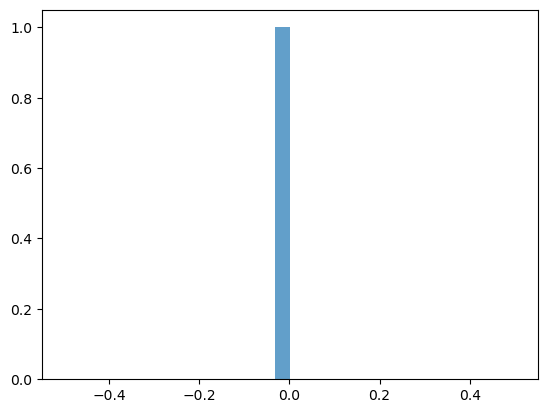

In [17]:
import seaborn as sns
from scipy import stats

def prior_sampling(draws = 100, alpha=2, beta=8):
    """
    Prior distribution for mutation rates.
    alpha: First parameter.
    beta: Second parameter.
    """
    x = np.random.uniform(alpha, beta, draws)
    mu_sim = 10 ** (-x)
    return mu_sim

# number of experiments
values_sim = [150]

# Initialise array of inferred mutation rates across different number of experiments
infer_mu = []
for j in values_sim:
  # Generate 'observed' mutant counts with given mutation rate
  tot_pop_bf_drug, mut_event_bf_drug, tot_mut_bf_drug, tot_pop_per, tot_pop_af_drug, per_event_af_drug, fin_per, tot_mut_af_drug, mut_event_from_per, mut_event_from_normal, tot_mut_until_end, tot_mut_event = run_simulations(
    initial_population, initial_time, max_birth_time,
    end_time, growth_rate,
    death_rate_treated, persister_rate, mutation_rate_persister,
    mutation_rate_sensitive, death_rate_persister,j)

  # Draw 100 simulations from prior
  mu_sim = prior_sampling(100, 2, 9)

  observed_sorted = np.sort(tot_mut_bf_drug)

  # Compute empirical CDF
  cdf = np.arange(1, len(observed_sorted) + 1) / len(observed_sorted)

  # Initialise array containing Kolmogorov-Smirnov statistics for each simulation
  ks_stat = np.zeros(100)

  # Mutant counts for each simulation
  all_mutant_counts = np.zeros(100 * j)
  for i in range(100):
    # Do LD experiment for mutation rate from prior
    tot_pop_bf_drug, mut_event_bf_drug, sample_mutant_counts, tot_pop_per, tot_pop_af_drug, per_event_af_drug, fin_per, tot_mut_af_drug, mut_event_from_per, mut_event_from_normal, tot_mut_until_end, tot_mut_event = run_simulations(
      initial_population, initial_time, max_birth_time,
      end_time, growth_rate,
      death_rate_treated, persister_rate, mutation_rate_persister,
      mu_sim[i], death_rate_persister,j)

    # Compute CDF for simulation
    sample_sorted = np.sort(sample_mutant_counts)
    all_mutant_counts[j * i : j * (i + 1)] = sample_mutant_counts
    sample_cdf = np.arange(1, len(sample_sorted) + 1) / len(sample_sorted)

    # Kolmogorov-Smirnov statistic
    ks = stats.kstest(tot_mut_bf_drug, sample_mutant_counts)
    ks_stat[i] = ks.statistic

  # Filter appropriate simulations with K-S statistics withing the given threshold
  colors = sns.color_palette("tab10", 100)
  good_samples_id = np.where(ks_stat < 0.13)[0]
  good_samples_mu = mu_sim[good_samples_id]

  # Histogram of mutation rates
  plt.hist(good_samples_mu, bins=30, alpha = 0.7, label='mutation rate')
  print("Chosen mutation rate from prior: ", np.mean(good_samples_mu))

#### In drug treatment phase - mutation rate for persister

Running simulations: 100%|████████████████████| 150/150 [00:03<00:00, 47.56it/s]


Running simulations: 100%|████████████████████| 150/150 [00:03<00:00, 45.25it/s]


Running simulations: 100%|████████████████████| 150/150 [00:03<00:00, 49.26it/s]


Running simulations: 100%|████████████████████| 150/150 [00:02<00:00, 57.16it/s]


Running simulations: 100%|████████████████████| 150/150 [00:02<00:00, 55.11it/s]


Running simulations: 100%|████████████████████| 150/150 [00:02<00:00, 53.82it/s]


Running simulations: 100%|████████████████████| 150/150 [00:03<00:00, 43.45it/s]

Chosen mutation rate from prior:  0.0006997044701376619


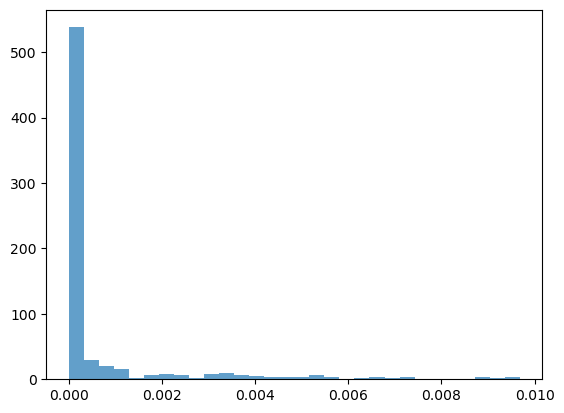

In [22]:
def prior_sampling(draws = 100, alpha=2, beta=8):
    """
    Prior distribution for mutation rates.
    alpha: First parameter.
    beta: Second parameter.
    """
    x = np.random.uniform(alpha, beta, draws)
    mu_sim = 10 ** (-x)
    return mu_sim

# Array containing number of experiments
values_sim = [150]

# Initialise array of inferred mutation rates across different number of experiments
infer_mu = []
for j in values_sim:
  # Generate 'observed' mutant counts with given mutation rate
  tot_pop_bf_drug, mut_event_bf_drug, tot_mut_bf_drug, tot_pop_per, tot_pop_af_drug, per_event_af_drug, fin_per, tot_mut_af_drug, mut_event_from_per, mut_event_from_normal, tot_mut_until_end, tot_mut_event = run_simulations(
    initial_population, initial_time, max_birth_time,
    end_time, growth_rate,
    death_rate_treated, persister_rate, mutation_rate_persister,
    mutation_rate_sensitive, death_rate_persister,j)

  # Draw 700 simulations from prior
  mu_sim = prior_sampling(700, 2, 9)

  observed_sorted = np.sort(tot_pop_per)

  # Compute empirical CDF
  cdf = np.arange(1, len(observed_sorted) + 1) / len(observed_sorted)

  # Initialise array containing Kolmogorov-Smirnov statistics for each simulation
  ks_stat = np.zeros(700)

  # Mutant counts for each simulation
  all_mutant_counts = np.zeros(700 * j)
  for i in range(700):
    # Do LD experiment for mutation rate from prior
    tot_pop_bf_drug, mut_event_bf_drug, tot_mut_bf_drug, sample_mutant_counts, tot_pop_af_drug, per_event_af_drug, fin_per, tot_mut_af_drug, mut_event_from_per, mut_event_from_normal, tot_mut_until_end, tot_mut_event = run_simulations(
      initial_population, initial_time, max_birth_time,
      end_time, growth_rate,
      death_rate_treated, persister_rate, mu_sim[i],
      mutation_rate_sensitive, death_rate_persister,j)

    # Compute CDF for simulation
    sample_sorted = np.sort(sample_mutant_counts)
    all_mutant_counts[j * i : j * (i + 1)] = sample_mutant_counts
    sample_cdf = np.arange(1, len(sample_sorted) + 1) / len(sample_sorted)

    # Kolmogorov-Smirnov statistic
    ks = stats.kstest(tot_pop_per, sample_mutant_counts)
    ks_stat[i] = ks.statistic

  # Filter appropriate simulations with K-S statistics withing the given threshold
  colors = sns.color_palette("tab10", 700)
  good_samples_id = np.where(ks_stat < 0.13)[0]
  good_samples_mu = mu_sim[good_samples_id]

  # Histogram of mutation rates
  plt.hist(good_samples_mu, bins=30, alpha = 0.7, label='mutation rate')
  print("Chosen mutation rate from prior: ", np.mean(good_samples_mu))